### Operating Discriminator on Embedding Space instead of image space using **WASSERSTEIN GAN**

Checking if GAN works fine if discriminator is made to differenciate on embedding space rather than image space. The embedding function $\phi$ is fixed with random weights.

<img src = 'images/emGAN.png' width=500 height=500/>

where **generator G** is fully convolutional as follows :-

<img src = 'images/emGAN_G.png' width=300 height=300/>

and **discriminator D** is densely connected as follows :-

<img src = 'images/emGAN_E.png' width=300 height=300/>

The **embedding network E** contains two convolutional layers initialized with random weights which are fixed. So, we can say that the embedding network is a fixed mapping from the output space of the generator to the input space of discriminator :- 

<img src = 'images/emGAN_D.png' width=300 height=300/>


## Some common functions

In [11]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision


# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

In [12]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [13]:
# number of GPUs available
ngpu = 2

batchSize = 256

numNoiseChannels = 100
numGenFilter = 64
numDiscFilter = 64

learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32

# for conditional GAN / auxillary classifier GAN
numClasses = 10

# for Wasserstein GAN
learningRate = 0.00005

#
discIter = 5

In [14]:
modelFolder = 'dummy'

GInitF = 'G_init.pt'
DInitF = 'D_init.pt'
EInitF = 'E_init.pt'

GFinalF = 'G_fin.pt'
DFinalF = 'D_fin.pt'
EFinalF = 'E_fin.pt'


def change():
    
    GInit = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator()
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator()
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'

def change_C():
    
    GInit = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GInitF
    GInit.load_state_dict(torch.load(PATH))

    DInit = Discriminator(numClasses)
    PATH = modelFolder + '/' + DInitF
    DInit.load_state_dict(torch.load(PATH))

    EInit = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EInitF
    EInit.load_state_dict(torch.load(PATH))
    
    
    GFin = Generator(numNoiseChannels, numClasses, numGenFilter, numPrimaryOutputChannels)
    PATH = modelFolder + '/' + GFinalF
    GFin.load_state_dict(torch.load(PATH))

    DFin = Discriminator(numClasses)
    PATH = modelFolder + '/' + DFinalF
    DFin.load_state_dict(torch.load(PATH))

    EFin = EmbeddingNet(numPrimaryOutputChannels)
    PATH = modelFolder + '/' + EFinalF
    EFin.load_state_dict(torch.load(PATH))
    
    GFlag = True    
    DFlag = True
    EFlag = True
    
    for m in GFin._modules:   
        if isinstance(GFin._modules[m], nn.ConvTranspose2d) or isinstance(GFin._modules[m],nn.BatchNorm2d):
            GFlag = GFlag and (GFin._modules[m].weight == GInit._modules[m].weight).data.all()
    

    for m in DFin._modules:
        if isinstance(DFin._modules[m], nn.Linear) or isinstance(DFin._modules[m],nn.BatchNorm2d):
            DFlag = DFlag and (DFin._modules[m].weight == DInit._modules[m].weight).data.all()
    
    
    for m in EFin._modules:
        if isinstance(EFin._modules[m], nn.Conv2d) or isinstance(EFin._modules[m],nn.BatchNorm2d):
            EFlag = EFlag and (EFin._modules[m].weight == EInit._modules[m].weight).data.all()

    if GFlag:
        print 'Generator: Weights are same'
    else:
        print 'Generator: Weights are different'
        
    if DFlag:
        print 'Discriminator: Weights are same'
    else:
        print 'Discriminator: Weights are different'

    if EFlag:
        print 'Embedding: Weights are same'
    else:
        print 'Embedding: Weights are different'

This notebook contains of the below four experiments :-

- A **randomly** initialized embedding layer *E* with **W-DC-GAN**
    - MNIST
    - SVHN
- A **triplet** loss initalized embedding layer *E* with **W-DC-GAN**
    - MNIST ( $\boldsymbol{\theta}$ from the trained network )
    - SVHN  ($\boldsymbol{\phi}$ from the trained network)
- A **contrastive** initialized embedding layer *E* with **W-DC-GAN**
    - MNIST ($\boldsymbol{\theta}$ from the trained network)
    - SVHN  ($\boldsymbol{\phi}$ from the trained network)

## Function for training Wasserstrin GAN

In [15]:
def train_W1(primaryTrainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numNoiseChannels, numGenFilter, numPrimaryOutputChannels, ngpu)
    D = Discriminator(numDiscFilter, numPrimaryOutputChannels)
    
    #initialize the weights here
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    

    PATH = modelFolder+'/' + GInitF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DInitF
    torch.save(D.state_dict(), PATH)

    

    
    # take the binary cross entropy loss 
    #lossFunction = nn.BCELoss()
    
    # change the optimizer to rmsprop as in Wasserstein GAN
    genOptimizer = optim.RMSprop(G.parameters(),
                              lr=learningRate)
    discOptimizer = optim.RMSprop(D.parameters(),
                               lr=learningRate)
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numPrimaryOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numNoiseChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numNoiseChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    

    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        #lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts   
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(primaryTrainLoader, 0):
            
            # train discriminator D
            
            for i in range(discIter):
                
                # weight clamping in Wasserstein GAN - Discriminator
                for param in D.parameters():
                    param.data.clamp_(-0.01, 0.01)

                # set the gradients in computation graph of discriminator to be 0
                D.zero_grad()
                dataInstance, dataLabel = data
                if cuda:
                    dataInstance = dataInstance.cuda()

                # train discriminator on real classes
                discRealInput.copy_(dataInstance)

                discRealInputV = Variable(discRealInput)
                discRealLabelV = Variable(discRealLabel)


                #print discRealInputV.data.shape, discRealInputEmbedding.data.shape

                #print discRealInput.shape
                discRealOutput = D(discRealInputV)



                # train discriminator on fake classes
                discFakeInput.normal_(0,1)
                discFakeInputV = Variable(discFakeInput)
                discFakeLabelV = Variable(discFakeLabel)

                genFakeOutput = G(discFakeInputV)


                # detach the graph prior to D. So what weights in G do not get updated
                discFakeOutput = D(genFakeOutput.detach())

                # wasserstein GAN loss discriminator
                discriminatorLoss = -(torch.mean(discRealOutput)- torch.mean(discFakeOutput))
                discriminatorLoss.backward()

                

                # update the weights
                discOptimizer.step()
            
            # log the loss for discriminator
            discriminatorLosses.append((discriminatorLoss).data[0])
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput)
            
            # wasserstein GAN loss discriminator
            generatorLoss = -torch.mean(discFakeOutput)
            
            generatorLoss.backward()
            
            # log the loss for generator
            generatorLosses.append(generatorLoss.data[0])
            
            genOptimizer.step()
            
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    fig.savefig('MNIST_100.png')
    showTrainHist(trainHist)
    
    PATH = modelFolder+'/' + GFinalF
    torch.save(G.state_dict(), PATH)
    PATH = modelFolder+'/' + DFinalF
    torch.save(D.state_dict(), PATH)


# Now using the Wasserstein - GAN for experiments


In [16]:
from model_exp0a_W import Generator, Discriminator, EmbeddingNet

In [17]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'MNIST'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [ ]:
embeddingNet = EmbeddingNet

Epoch : [1/30] time: 290.94, loss_d: -0.663, loss_g: 0.285
Epoch : [2/30] time: 292.63, loss_d: -0.705, loss_g: 0.226
Epoch : [3/30] time: 292.65, loss_d: -0.726, loss_g: 0.224
Epoch : [4/30] time: 292.58, loss_d: -0.732, loss_g: 0.222
Epoch : [5/30] time: 292.89, loss_d: -0.733, loss_g: 0.222
Epoch : [6/30] time: 292.94, loss_d: -0.734, loss_g: 0.225
Epoch : [7/30] time: 292.99, loss_d: -0.721, loss_g: 0.222
Epoch : [8/30] time: 292.94, loss_d: -0.677, loss_g: 0.210
Epoch : [9/30] time: 293.10, loss_d: -0.582, loss_g: 0.171
Epoch : [10/30] time: 293.24, loss_d: -0.494, loss_g: 0.135
Epoch : [11/30] time: 293.33, loss_d: -0.461, loss_g: 0.099
Epoch : [12/30] time: 293.43, loss_d: -0.431, loss_g: 0.102
Epoch : [13/30] time: 293.62, loss_d: -0.401, loss_g: 0.089
Epoch : [14/30] time: 293.65, loss_d: -0.389, loss_g: 0.087
Epoch : [15/30] time: 293.45, loss_d: -0.376, loss_g: 0.078
Epoch : [16/30] time: 293.73, loss_d: -0.369, loss_g: 0.066
Epoch : [17/30] time: 293.82, loss_d: -0.359, los

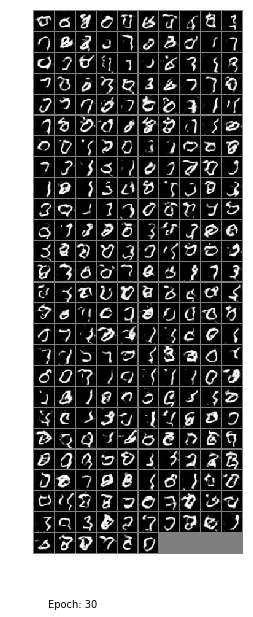

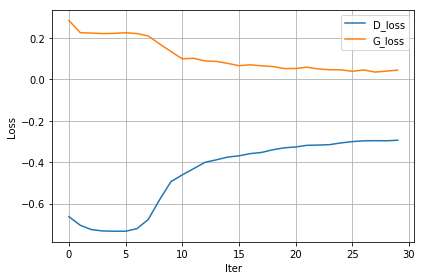

In [22]:
train_W1(primaryTrainLoader,  epochs = 30)

Epoch : [1/50] time: 289.30, loss_d: -0.726, loss_g: 0.309
Epoch : [2/50] time: 291.63, loss_d: -0.744, loss_g: 0.214
Epoch : [3/50] time: 291.21, loss_d: -0.755, loss_g: 0.211
Epoch : [4/50] time: 291.15, loss_d: -0.760, loss_g: 0.211
Epoch : [5/50] time: 291.25, loss_d: -0.759, loss_g: 0.211
Epoch : [6/50] time: 291.86, loss_d: -0.760, loss_g: 0.212
Epoch : [7/50] time: 291.87, loss_d: -0.757, loss_g: 0.211
Epoch : [8/50] time: 291.92, loss_d: -0.753, loss_g: 0.212
Epoch : [9/50] time: 291.81, loss_d: -0.740, loss_g: 0.212
Epoch : [10/50] time: 292.04, loss_d: -0.686, loss_g: 0.198
Epoch : [11/50] time: 292.26, loss_d: -0.591, loss_g: 0.162
Epoch : [12/50] time: 292.32, loss_d: -0.497, loss_g: 0.118
Epoch : [13/50] time: 292.52, loss_d: -0.455, loss_g: 0.092
Epoch : [14/50] time: 292.44, loss_d: -0.431, loss_g: 0.089
Epoch : [15/50] time: 292.06, loss_d: -0.412, loss_g: 0.074
Epoch : [16/50] time: 291.87, loss_d: -0.392, loss_g: 0.066
Epoch : [17/50] time: 291.90, loss_d: -0.378, los

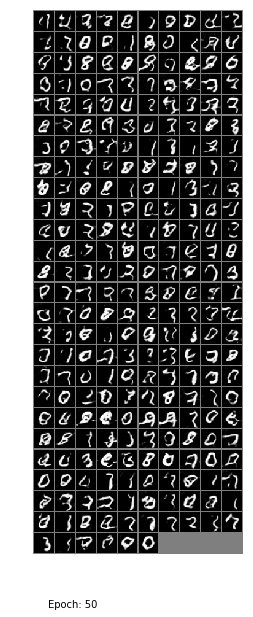

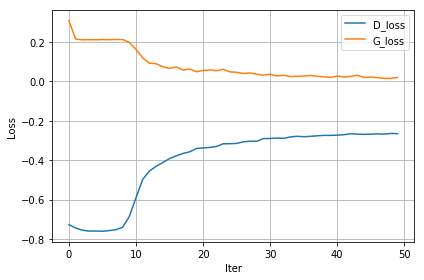

In [ ]:
train_W1(primaryTrainLoader,  epochs = 50)

### SVHN Dataset

In [7]:
# define theta and phi embedding networks according to the loss used ie contrastive or triplet
primaryDataset = 'SVHN'
numPrimaryOutputChannels = getChannels(primaryDataset)

classes = [0,1,2,3,4,5,6,7,8,9]
instances = [7000 for i in range(10)]
kwargs = {'num_workers': 1, 'pin_memory': True, 'drop_last':True} if cuda else {}

# raw test data, seperate for both the primary and helper class
trainDatasetPrimary = loadDataset(primaryDataset, classes, instances,'train')

# raw test data, seperate for both the primary and helper class
testDatasetPrimary = loadDataset(primaryDataset, classes, instances,'test')

primaryTrainLoader = torch.utils.data.DataLoader(trainDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primaryTestLoader = torch.utils.data.DataLoader(testDatasetPrimary, batch_size=batchSize, shuffle=True, **kwargs)

In [8]:
embeddingNet = EmbeddingNet

Epoch : [1/10] time: 295.48, loss_d: -0.497, loss_g: 0.230
Epoch : [2/10] time: 296.38, loss_d: -0.499, loss_g: 0.219
Epoch : [3/10] time: 296.37, loss_d: -0.441, loss_g: 0.196
Epoch : [4/10] time: 296.45, loss_d: -0.386, loss_g: 0.178
Epoch : [5/10] time: 296.53, loss_d: -0.429, loss_g: 0.191
Epoch : [6/10] time: 296.39, loss_d: -0.492, loss_g: 0.217
Epoch : [7/10] time: 296.34, loss_d: -0.469, loss_g: 0.209
Epoch : [8/10] time: 296.33, loss_d: -0.476, loss_g: 0.210
Epoch : [9/10] time: 296.04, loss_d: -0.473, loss_g: 0.207
Epoch : [10/10] time: 295.89, loss_d: -0.473, loss_g: 0.200


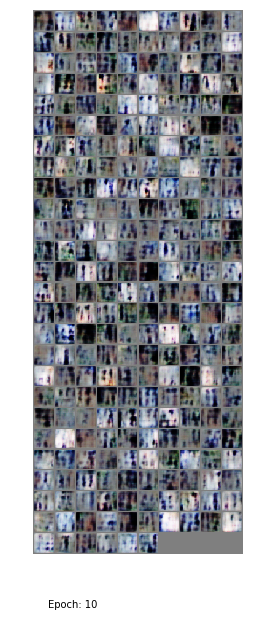

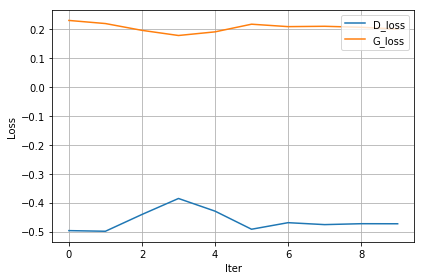

In [12]:
train_W1(primaryTrainLoader,  epochs = 10)

Epoch : [1/30] time: 296.38, loss_d: -0.493, loss_g: 0.232
Epoch : [2/30] time: 295.50, loss_d: -0.486, loss_g: 0.208
Epoch : [3/30] time: 295.55, loss_d: -0.388, loss_g: 0.181
Epoch : [4/30] time: 295.63, loss_d: -0.425, loss_g: 0.207
Epoch : [5/30] time: 295.80, loss_d: -0.454, loss_g: 0.217
Epoch : [6/30] time: 295.87, loss_d: -0.494, loss_g: 0.236
Epoch : [7/30] time: 295.73, loss_d: -0.481, loss_g: 0.230
Epoch : [8/30] time: 295.50, loss_d: -0.496, loss_g: 0.236
Epoch : [9/30] time: 295.47, loss_d: -0.464, loss_g: 0.220
Epoch : [10/30] time: 295.49, loss_d: -0.485, loss_g: 0.245
Epoch : [11/30] time: 295.61, loss_d: -0.457, loss_g: 0.223
Epoch : [12/30] time: 295.62, loss_d: -0.478, loss_g: 0.240
Epoch : [13/30] time: 295.65, loss_d: -0.458, loss_g: 0.227
Epoch : [14/30] time: 295.50, loss_d: -0.477, loss_g: 0.235
Epoch : [15/30] time: 295.40, loss_d: -0.436, loss_g: 0.221
Epoch : [16/30] time: 295.41, loss_d: -0.442, loss_g: 0.218
Epoch : [17/30] time: 295.25, loss_d: -0.447, los

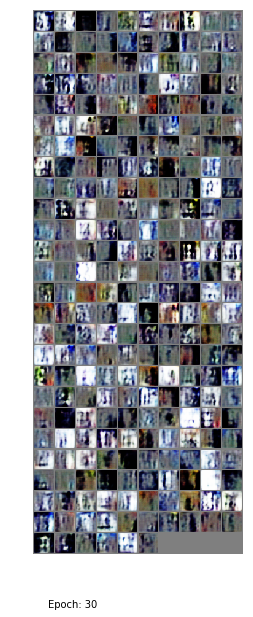

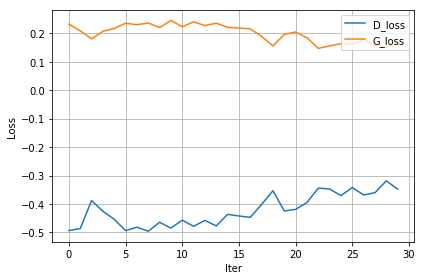

In [9]:
train_W1(primaryTrainLoader,  epochs = 30)

In [ ]:
train_W1(primaryTrainLoader,  epochs = 50)

Epoch : [1/50] time: 296.24, loss_d: -0.523, loss_g: 0.309
Epoch : [2/50] time: 296.35, loss_d: -0.481, loss_g: 0.225
Epoch : [3/50] time: 296.28, loss_d: -0.470, loss_g: 0.216
Epoch : [4/50] time: 296.01, loss_d: -0.457, loss_g: 0.212
Epoch : [5/50] time: 296.21, loss_d: -0.462, loss_g: 0.208
Epoch : [6/50] time: 296.10, loss_d: -0.492, loss_g: 0.238
Epoch : [7/50] time: 296.18, loss_d: -0.472, loss_g: 0.231
Epoch : [8/50] time: 296.18, loss_d: -0.440, loss_g: 0.197
Epoch : [9/50] time: 296.00, loss_d: -0.349, loss_g: 0.165
Epoch : [10/50] time: 296.19, loss_d: -0.338, loss_g: 0.152
Epoch : [11/50] time: 295.78, loss_d: -0.519, loss_g: 0.239
Epoch : [12/50] time: 296.21, loss_d: -0.501, loss_g: 0.224
Epoch : [13/50] time: 296.16, loss_d: -0.515, loss_g: 0.234
Epoch : [14/50] time: 295.74, loss_d: -0.522, loss_g: 0.239
Epoch : [15/50] time: 295.95, loss_d: -0.478, loss_g: 0.219
Epoch : [16/50] time: 295.66, loss_d: -0.480, loss_g: 0.226
Epoch : [17/50] time: 296.18, loss_d: -0.446, los